<a href="https://colab.research.google.com/github/ErickMM98/covid-ct-network-analysis/blob/main/covid_mfdfa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargamos los datos.



In [1]:
!mkdir data
!mkdir data/covid
!mkdir data/normal

In [2]:
#@title For COVID Cases
!wget http://ncov-ai.big.ac.cn/download/COVID19-27.zip

--2021-10-10 06:52:33--  http://ncov-ai.big.ac.cn/download/COVID19-27.zip
Resolving ncov-ai.big.ac.cn (ncov-ai.big.ac.cn)... 124.16.164.43
Connecting to ncov-ai.big.ac.cn (ncov-ai.big.ac.cn)|124.16.164.43|:80... connected.
HTTP request sent, awaiting response... 200 
Length: 79485632 (76M) [application/octet-stream]
Saving to: ‘COVID19-27.zip’

COVID19-27.zip      100%[===================>]  75.80M   351KB/s    in 3m 52s  

2021-10-10 06:56:28 (335 KB/s) - ‘COVID19-27.zip’ saved [79485632/79485632]



In [3]:
#@title For normal cases
!wget http://ncov-ai.big.ac.cn/download/Normal-8.zip

--2021-10-10 06:56:28--  http://ncov-ai.big.ac.cn/download/Normal-8.zip
Resolving ncov-ai.big.ac.cn (ncov-ai.big.ac.cn)... 124.16.164.43
Connecting to ncov-ai.big.ac.cn (ncov-ai.big.ac.cn)|124.16.164.43|:80... connected.
HTTP request sent, awaiting response... 200 
Length: 89250877 (85M) [application/octet-stream]
Saving to: ‘Normal-8.zip’

Normal-8.zip        100%[===================>]  85.12M   347KB/s    in 4m 22s  

2021-10-10 07:00:52 (333 KB/s) - ‘Normal-8.zip’ saved [89250877/89250877]



In [4]:
!unzip COVID19-27.zip -d data/covid
!unzip Normal-8.zip -d data/normal

Streaming output truncated to the last 5000 lines.
  inflating: data/covid/NCP/1050/2624/0213.JPG  
  inflating: data/covid/NCP/1050/2624/0073.JPG  
  inflating: data/covid/NCP/1050/2624/0133.JPG  
  inflating: data/covid/NCP/1050/2624/0081.JPG  
  inflating: data/covid/NCP/1050/2624/0068.JPG  
  inflating: data/covid/NCP/1050/2624/0428.JPG  
  inflating: data/covid/NCP/1050/2624/0193.JPG  
  inflating: data/covid/NCP/1050/2624/0185.JPG  
  inflating: data/covid/NCP/1050/2624/0118.JPG  
  inflating: data/covid/NCP/1050/2624/0147.JPG  
  inflating: data/covid/NCP/1050/2624/0092.JPG  
  inflating: data/covid/NCP/1050/2624/0364.JPG  
  inflating: data/covid/NCP/1050/2624/0178.JPG  
  inflating: data/covid/NCP/1050/2624/0187.JPG  
  inflating: data/covid/NCP/1050/2624/0341.JPG  
  inflating: data/covid/NCP/1050/2624/0204.JPG  
  inflating: data/covid/NCP/1050/2624/0356.JPG  
  inflating: data/covid/NCP/1050/2624/0385.JPG  
  inflating: data/covid/NCP/1050/2624/0265.JPG  
  inflating: data/

In [5]:
#@title Algunas dependencias de Python
from tqdm.auto import tqdm

In [ ]:
#!wget http://ncov-ai.big.ac.cn/download/ct_lesion_seg.zip

--2021-10-06 08:09:37--  http://ncov-ai.big.ac.cn/download/ct_lesion_seg.zip
Resolving ncov-ai.big.ac.cn (ncov-ai.big.ac.cn)... 124.16.164.43
Connecting to ncov-ai.big.ac.cn (ncov-ai.big.ac.cn)|124.16.164.43|:80... connected.
HTTP request sent, awaiting response... 200 
Length: 884253723 (843M) [application/octet-stream]
Saving to: ‘ct_lesion_seg.zip’

ct_lesion_seg.zip   100%[===================>] 843.29M  11.1MB/s    in 79s     

2021-10-06 08:10:58 (10.7 MB/s) - ‘ct_lesion_seg.zip’ saved [884253723/884253723]



In [ ]:
#!mv /content/ct_lesion_seg.zip /content/drive/MyDrive/covid-ct-bronquial-tree
!unzip ct_lesion_seg.zip -d /content/foo_data

# Presentamos MF-DFA

Particionamos la imagen a cuadros de longitud $s$.

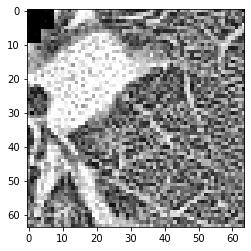

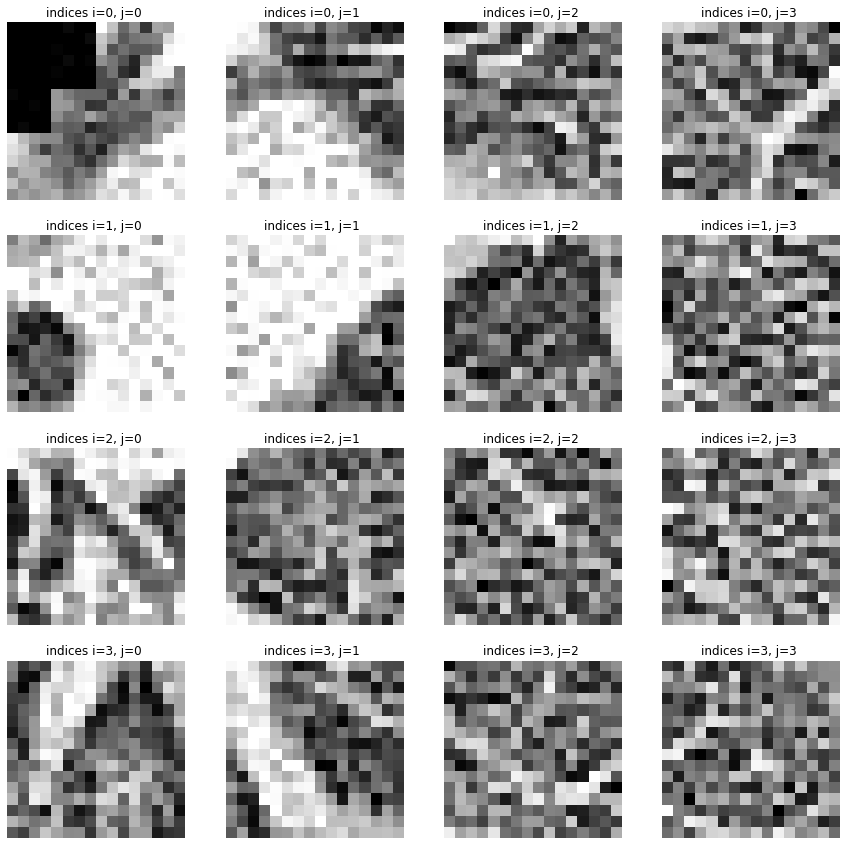

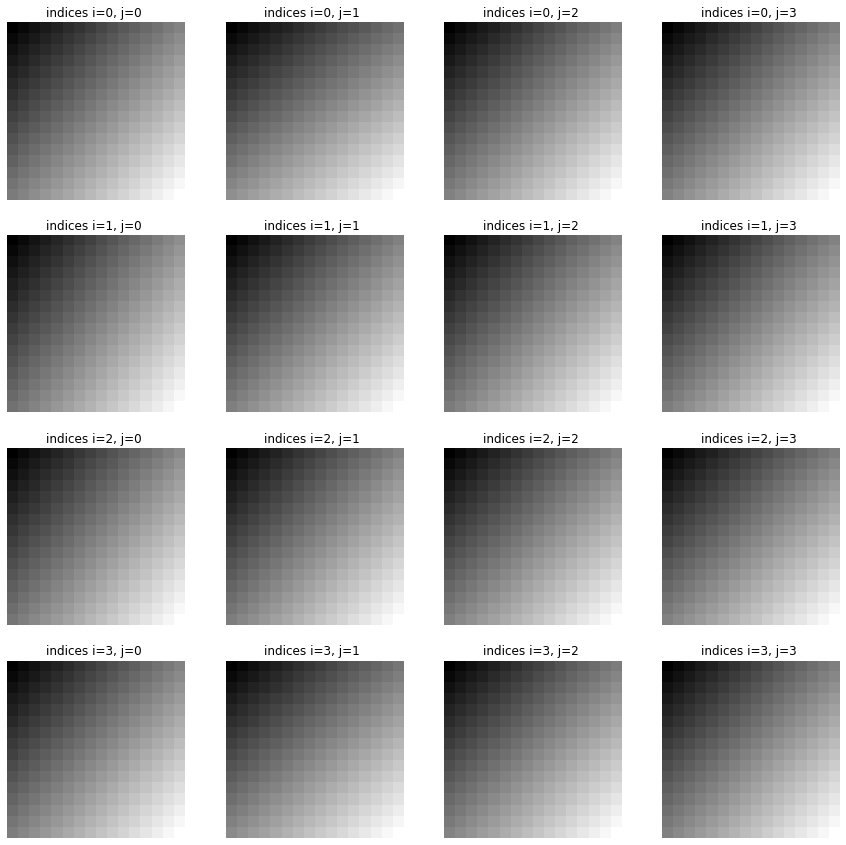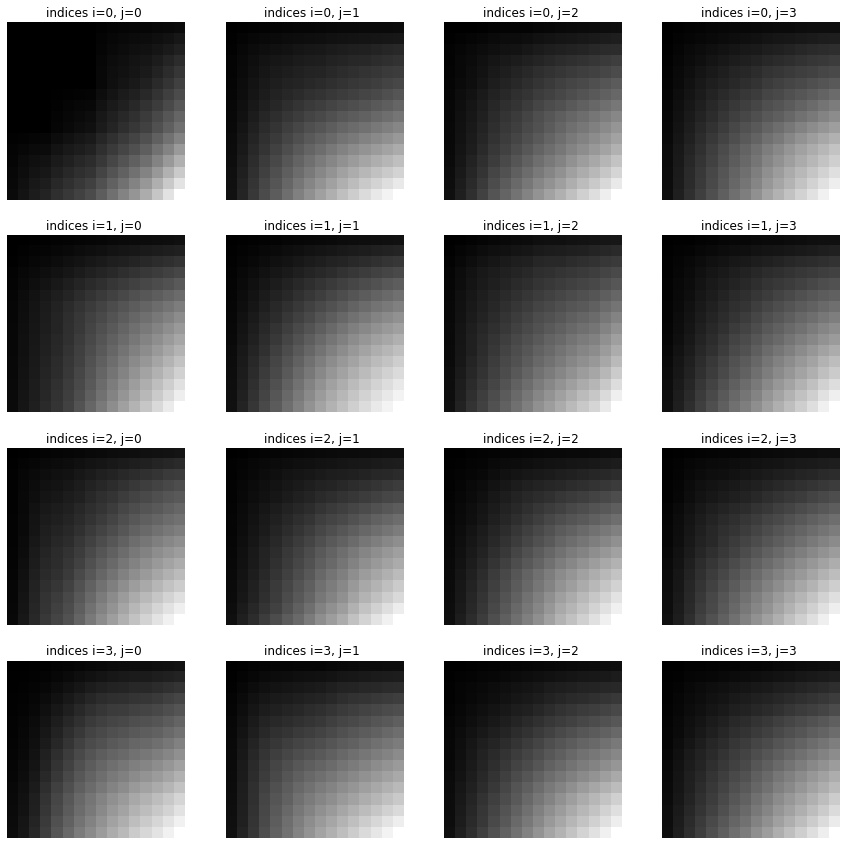

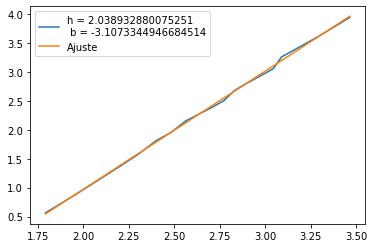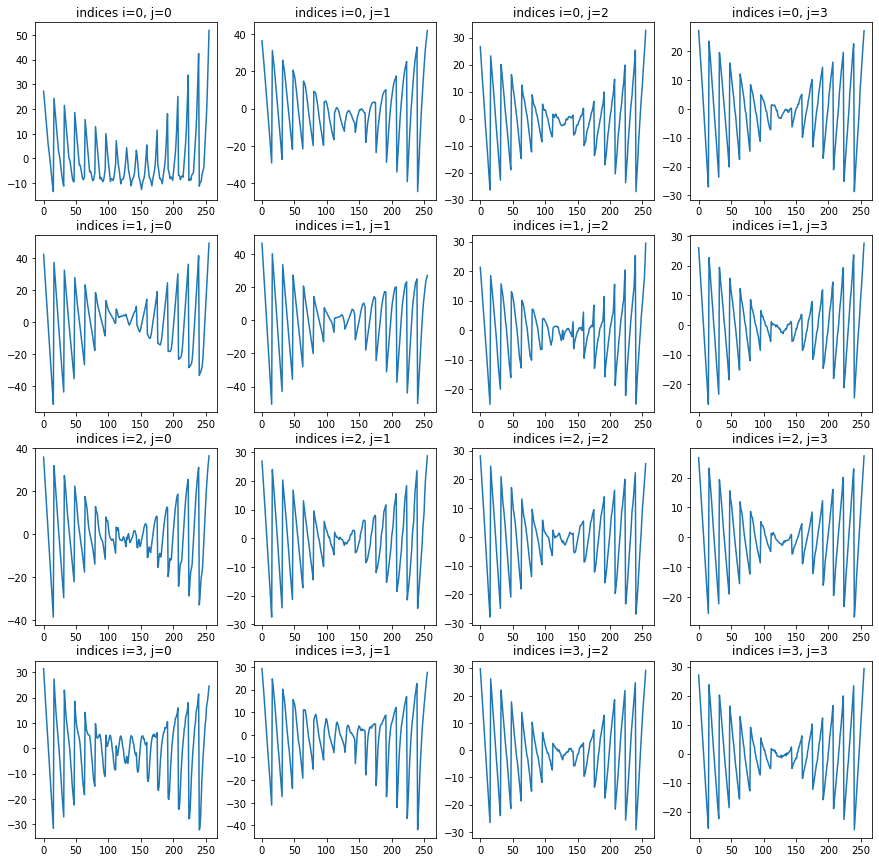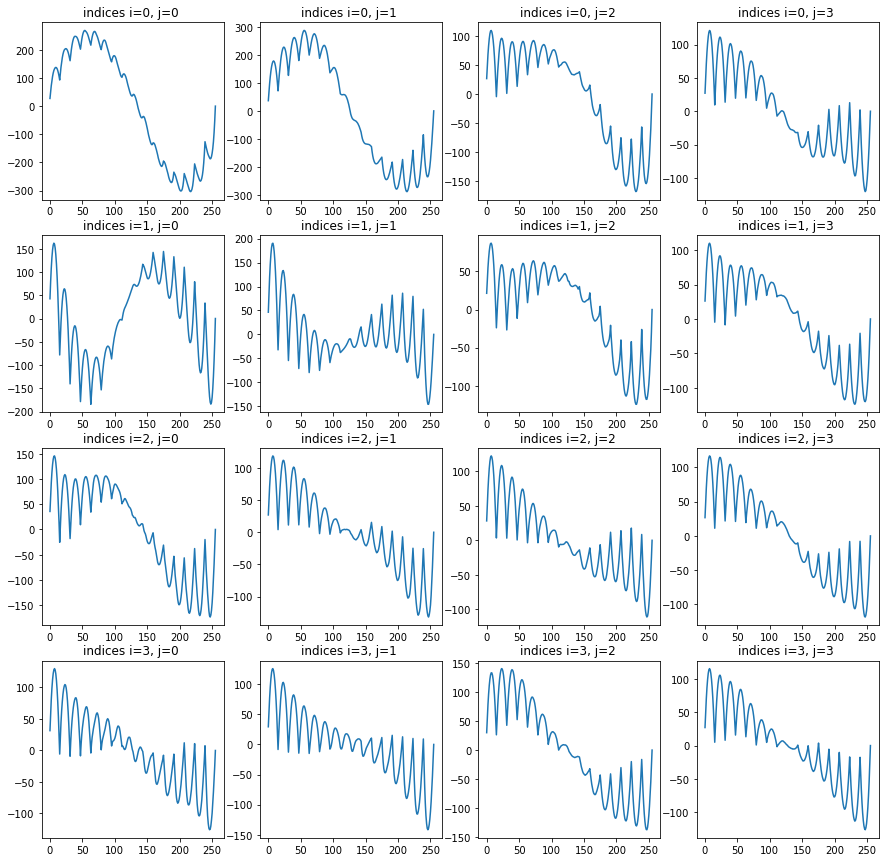

# Codigo

In [ ]:
#@title MFDFA main
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 13 16:12:49 2021

@author: Erick Muñiz Morales

Modules to image segmentation by multifractal detrendted
fluctiation analysis. 


"""

import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import os
from skimage.filters import gaussian
from skimage.exposure import equalize_adapthist

str_path_covid = 'data/foo_image/covid.JPG'


"""
------- BEGIN MODULAR FUNCTIONS
"""

def get_windows_size_w_by_pixel(img, i,j,w=11):
    """
    

    Parameters
    ----------
    img : TYPE
        DESCRIPTION.
    i : TYPE
        DESCRIPTION.
    j : TYPE
        DESCRIPTION.
    w : TYPE, optional
        DESCRIPTION. The default is 11.

    Returns
    -------
    TYPE
        DESCRIPTION.

    """
    N = img.shape[0]
    M = img.shape[1]
    min_x = max([ i-w, 0 ])
    max_x = min([ i+w, N ])
    
    min_y = max([ i-w, 0 ])
    max_y = min([ i+w, M ])
    
    return img[min_x:max_x, min_y:max_y]
    

def get_window_size_s(img,i,j,s):
    """
    Parameters
    ----------
    img : skimae.io.imread (ndarray); the whole image
        the whole image
    s : size of the window of fluctiation
        DESCRIPTION.
    i : row index
        is less of N_s
    j : column index
        is less of M_s

    Returns
    -------
    TYPE
        The image window of size s with index i,j in the new fluctuation.

    """
    min_x = i*s
    max_x = (i+1)*s
    min_y = j*s
    max_y = (j+1)*s
    return img[min_x:max_x, min_y:max_y]

def get_cumulative_matrix(img):
    """
    Get the sum cumulative matrix of the squared matrix (img).

    Parameters
    ----------
    img : Matrix of values.
        DESCRIPTION.

    Returns
    -------
    None.

    """
    N = img.shape[0]
    
    matrix_ones = np.ones((N,N))
    
    rigth_matrix = np.triu(matrix_ones)
    left_matrix = np.tril(matrix_ones)
    
    return left_matrix @ img @ rigth_matrix
    
def make_var_least_squared_cum_matrix(cum_matrix, vectors = False):
    """
    A linear regresion of the window

    Parameters
    ----------
    cum_matrix : TYPE
        DESCRIPTION.

    Returns
    -------
    None.

    """
    
    N = cum_matrix.shape[0]
    
    A = []
    y = []
    for i in range(N):
        for j in range(N):
            renglon = [i+1,j+1,1]
            A.append(renglon)
            y.append([cum_matrix[i,j]])
            
    A = np.array(A)
    y = np.array(y)
    #print(A,y)
    alpha = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),y)
    
    y_pred = A @ alpha
    y_real = y
    
    if vectors:
        return y_real.ravel(), y_pred.ravel(), y_pred.reshape((N,N))
    else:
        return np.mean((y_real.ravel() - y_pred.ravel())**2)

def measure_fractal(array_var, q = 2):
    """
    For the other measures. 

    Parameters
    ----------
    array_var : TYPE
        DESCRIPTION.
    q : TYPE, optional
        DESCRIPTION. The default is 2.

    Returns
    -------
    None.

    """
    array_var = np.array(array_var)
    return np.mean( array_var**(q/2) )**(1/q)


def get_leas_squared_array(x,y):
    """
    The most simple least squered of two arrays. The model is in the form
                y = ax + b
    Parameters
    ----------
    x : TYPE
        DESCRIPTION.
    y : TYPE
        DESCRIPTION.

    Returns 
    -------
    a,b in the above formula.

    """
    
    x = np.array(x).reshape((len(x),1))
    y = np.array(y).reshape((len(y),1))
    A = np.concatenate( [x, np.ones((x.shape[0],1))] , axis=1)

    
    h = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),y)
    
    return h.ravel()


"""
------- END MODULAR FUNCTIONS
"""

"""
------- BEGIN PRINCIPAL FUNCTIONS
"""

def make_mfdfa_individual_window(window, s, q=2):
    """
    

    Parameters
    ----------
    window : TYPE
        DESCRIPTION.
    s : TYPE
        DESCRIPTION.
    q : TYPE, optional
        DESCRIPTION. The default is 2.

    Returns
    -------
    Fluctuation

    """
    
    N,M = window.shape
    
    N_s = int(N / s)
    M_s = int(M / s)
    
    #fig,ax = plt.subplots()
    #ax.imshow(window, cmap = 'gray')
    
    #fig, axes = plt.subplots(4,4)
    #fig.set_size_inches([15,15])
    #ax = axes.ravel()
    
    #k = 0
    
    #ESTO ES LO QUE SE PUEDE PARALELIZAR
    
    F_list_q = []
    for i in range(N_s):
        for j in range(M_s):
            X_mn = get_window_size_s(window, i, j, s)
            
            G_mn = get_cumulative_matrix(X_mn)
            
            y_real, y_pred, G_mn_pred = make_var_least_squared_cum_matrix(G_mn, vectors=True)
            
            y_mn = y_real - y_pred
            
            f_2mn = np.mean(y_mn**2)
            
            F_list_q.append(f_2mn)
            
            #ax[k].set_title("indices i={}, j={} ".format(i,j))
            #ax[k].imshow(G_mn_pred, cmap = 'gray' )
            #ax[k].plot(range(len(y_mn)),np.cumsum(y_mn), label = '{}'.format(f_2mn))
            #ax[k].legend()
            #ax[k].axis(False)
            
            #k +=1
            
    F_q = np.mean(np.array(F_list_q)**(q/2))**(1/q)
    
    #print(F_q)
    
    return F_q


def get_h_q_mfdfa(window, min_s = 6, max_s = None, q = 2):
    """
    Esta es la que debemos paralelizar    

    Parameters
    ----------
    window : TYPE
        DESCRIPTION.
    min_s : TYPE, optional
        DESCRIPTION. The default is 6.
    max_s : TYPE, optional
        DESCRIPTION. The default is None.
    q : TYPE, optional
        DESCRIPTION. The default is 2.

    Returns
    -------
    None.

    """
    s_ls = None
    y_ls = []
    
    N,M = window.shape
    
    if max_s == None:
        s_ls = range(min_s, int(min([N,M])/2) + 1 ,2)
    else:
        s_ls = range(min_s, max_s + 1 )
    
    for s in s_ls:
        #print(s)
        h = make_mfdfa_individual_window(window,s=s, q = 2)
        y_ls.append(h)
        
    h_q = get_leas_squared_array(np.log(s_ls), np.log(y_ls))
    
    return h_q[0]

def mfdfa_q_s(img, min_s = 6, max_s = None, q = 2, w= 16):
    """
    Function to get the image with the h value for each pixel. 

    Parameters
    ----------
    img : TYPE
        DESCRIPTION.
    min_s : TYPE, optional
        DESCRIPTION. The default is 6.
    max_s : TYPE, optional
        DESCRIPTION. The default is None.
    q : TYPE, optional
        DESCRIPTION. The default is 2.
    w : TYPE, optional
        DESCRIPTION. The default is 16.

    Returns
    -------
    None.

    """
    
    N,M = img.shape
    
    img_h = np.zeros( (N,M) )
    
    
    for ip in tqdm(range(N),desc='Progress'):
        for jp in range(M):
            if img[ip,jp] > 0:
                img_h[ip,jp] = 1
                window_pixel = get_windows_size_w_by_pixel(img,ip,jp,w=w)
                h_value = get_h_q_mfdfa(window_pixel,
                                    min_s=min_s,
                                    max_s=max_s,
                                    q = q)
                if h_value > 0:
                    img_h[ip,jp] = h_value
                else:
                    img_h[ip,jp] = 0
            else:
                img_h[ip,jp] = 0
    
    return img_h

#"""
#------- END PRINCIPAL FUNCTIONS
#"""

def get_h_image(img, q = 2):
    """
    

    Parameters
    ----------
    img : TYPE
        DESCRIPTION.
    q : TYPE, optional
        DESCRIPTION. The default is 2.

    Returns
    -------
    None.

    """
    
    s_ls = range(6, 17 + 1 )
    y_ls = []
    for s in s_ls:
        #print(s)
        h = make_mfdfa_individual_window(img,s=s, q = 2)
        y_ls.append(h)
        
    h_q = get_leas_squared_array(np.log(s_ls), np.log(y_ls))
    
    return h_q[0]

In [ ]:
#@title Segmentacion por flow network
import networkx as nx


def make_graph_segmentation(binaryimg, k = 1, lmd = 3.5):
	N,M = binaryimg.shape
	foo = binaryimg.copy()
	s,t = N*M, N*M + 1 
	G = nx.DiGraph()
	#Aqui generamos la red
	for idx, row in enumerate(binaryimg):
		for jdx, pixel in enumerate(row):
			#Polinomio de redireccionamiento
			px_id = (idx*len(row)) + jdx
			
			#Están arriba 
			if idx == 0: # or idx == N-1:
				#equina izquierda
				if jdx == 0:# or jdx == M-1:
					source = px_id
					#Derecha
					target = (idx*len(row)) + (jdx+1)
					G.add_edge(source, target, weight=k)
					#Abajo
					target = ((idx+1)*len(row)) + jdx
					G.add_edge(source, target, weight=k)
				#esquina Derecha
				elif jdx == M - 1:
					source = px_id
					#Izquierda
					target = (idx*len(row)) + (jdx-1)
					G.add_edge(source, target, weight=k)
					#Abajo
					target = ((idx+1)*len(row)) + jdx
					G.add_edge(source, target, weight=k)
				#En medio
				else:
					source = px_id
					#Derecha
					target = (idx*len(row)) + (jdx+1)
					G.add_edge(source, target, weight=k)
					#Izquierda
					target = (idx*len(row)) + (jdx-1)
					G.add_edge(source, target, weight=k)
					#Abajo
					target = ((idx+1)*len(row)) + jdx
					G.add_edge(source, target, weight=k)
			#Hasta abajo
			elif idx == N-1:
				#equina izquierda
				if jdx == 0:# or jdx == M-1:
					source = px_id
					#Derecha
					target = (idx*len(row)) + (jdx+1)
					G.add_edge(source, target, weight=k)
					#Arriba
					target = ((idx-1)*len(row)) + jdx
					G.add_edge(source, target, weight=k)
				#esquina Derecha
				elif jdx == M - 1:
					source = px_id
					#Izquierda
					target = (idx*len(row)) + (jdx-1)
					G.add_edge(source, target, weight=k)
					#Arriba
					target = ((idx-1)*len(row)) + jdx
					G.add_edge(source, target, weight=k)
				#En medio
				else:
					source = px_id
					#Derecha
					target = (idx*len(row)) + (jdx+1)
					G.add_edge(source, target, weight=k)
					#Izquierda
					target = (idx*len(row)) + (jdx-1)
					G.add_edge(source, target, weight=k)
					#Arriba
					target = ((idx-1)*len(row)) + jdx
					G.add_edge(source, target, weight=k)
			#En medio
			else:
				source = px_id

				#Derecha
				target = (idx*len(row)) + (jdx+1)
				G.add_edge(source, target, weight=k)

				#Izquierda
				target = (idx*len(row)) + (jdx-1)
				G.add_edge(source, target, weight=k)

				#Arriba
				target = ((idx-1)*len(row)) + jdx
				G.add_edge(source, target, weight=k)

				#Abajo
				target = ((idx+1)*len(row)) + jdx
				G.add_edge(source, target, weight=k)

			#Asociamos con s,t

			if pixel > 0:
				source = s
				target = px_id
				G.add_edge(source, target, weight=lmd)
			else:
				source = px_id
				target = t
				G.add_edge(source, target, weight=lmd)
	return G, s, t
# def make_binary_segmentation(binaryimg, k = 1, lmd = 3.5):
# 	N,M = binaryimg.shape
# 	G,s,t = make_graph_segmentation( binaryimg , k= k, lmd = lmd)
#   #cvalue,partition = nx.minimum_cut(G,_s = s,_t = t, capacity = 'weight')
# 	#real_pixels = np.array(list(partition[0]))
#   #array_pixels = np.arange(s)
#   #segment_img = np.isin(array_pixels, real_pixels).reshape(N,M)
# 	#return segment_img
# def make_binary_segmentation(binaryimg, k = 2, lmd = 3.5):
# 	N,M = binaryimg.shape

# 	G, s, t = make_graph_segmentation(binaryimg, 
# 	                                  k=k,lmd=lmd)
#  nx.minimum_cut(G,_s = s,_t = t, capacity = 'weight')

In [ ]:
path_covid_patients = 'data/covid/NCP/'
path_normal_patients = 'data/normal/Normal/'

list_id_pat = os.listdir(path_covid_patients)

In [ ]:
from skimage import io
from natsort import natsorted, ns
#moon = io.imread(filename)
list_frame = []
for folder in os.listdir(path_covid_patients + list_id_pat[9])[0:1]:
  for image in natsorted(os.listdir(path_covid_patients + list_id_pat[9] + '/' + folder)[:]):
    img = io.imread( path_covid_patients + list_id_pat[9] + '/' + folder +'/' + image)
    list_frame.append(img)

#Prueba para COVID

In [ ]:
from skimage.filters import gaussian
from skimage.exposure import equalize_adapthist


covid_foo = []

for i in tqdm(range(len(list_frame))[30:50]):
  img = list_frame[i]
  #primero equalizamos 
  foo_img = equalize_adapthist(img, clip_limit=0.02)

  val = get_h_image(foo_img)
  print(val)
  covid_foo.append(val)



#img = list_frame[18]#[200:264,120:184]

#foo_img = mfdfa_q_s(img,min_s= 2, max_s = 6, w=5)

  0%|          | 0/20 [00:00<?, ?it/s]

1.9740846907867156
1.9707226683260894
1.9725129027317232
1.9764471508192663
1.9723771345873269
1.9672191135984542
1.9740414309869496
1.969939127973124
1.9717629057114183
1.9716744755892965
1.9709865211891702
1.9715148680868078
1.9717653496484484
1.9713222660281817
1.9752506161228764
1.978893204877136
1.982783901402435
1.97398281853113
1.9747776145622242
1.9743519025945866


# Prueba para persona normal

In [ ]:
path_normal_patients = 'data/normal/Normal/'

list_id_pat = os.listdir(path_normal_patients)

list_frame = []
for folder in os.listdir(path_normal_patients + list_id_pat[0])[0:1]:
  for image in natsorted(os.listdir(path_normal_patients + list_id_pat[0] + '/' + folder)[:]):
    img = io.imread( path_normal_patients + list_id_pat[0] + '/' + folder +'/' + image)
    list_frame.append(img)

In [ ]:
normal_foo = []

for i in tqdm(range(len(list_frame))[30:50]):
  img = list_frame[i]
  #primero equalizamos 
  foo_img = equalize_adapthist(img, clip_limit=0.02)

  val = get_h_image(foo_img)
  print(val)
  normal_foo.append(val)

  0%|          | 0/20 [00:00<?, ?it/s]

1.9856748066826775
1.9846426555995704
1.9836951001043448
1.9807475759891449
1.9792055946215763
1.9793154089152145
1.9824362760775192
1.983966595635689
1.9874403693365403
1.9841567822307937
1.9852416323163065
1.9818369437176482
1.9758368787865492
1.974294756811606
1.974802424982548
1.9755940104301115
1.9738567129211666
1.9789148780515726
1.9841126717126285
1.9801039367453315


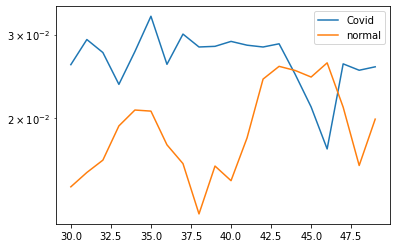

In [ ]:
covid_foo_foo = np.array(covid_foo)
normal_foo_foo = np.array(normal_foo)

fig, ax = plt.subplots()

ax.plot( range(30,50), 2-covid_foo_foo, label= 'Covid')
ax.plot( range(30,50), 2-normal_foo_foo, label= 'normal')
ax.set_yscale('log')
ax.legend()

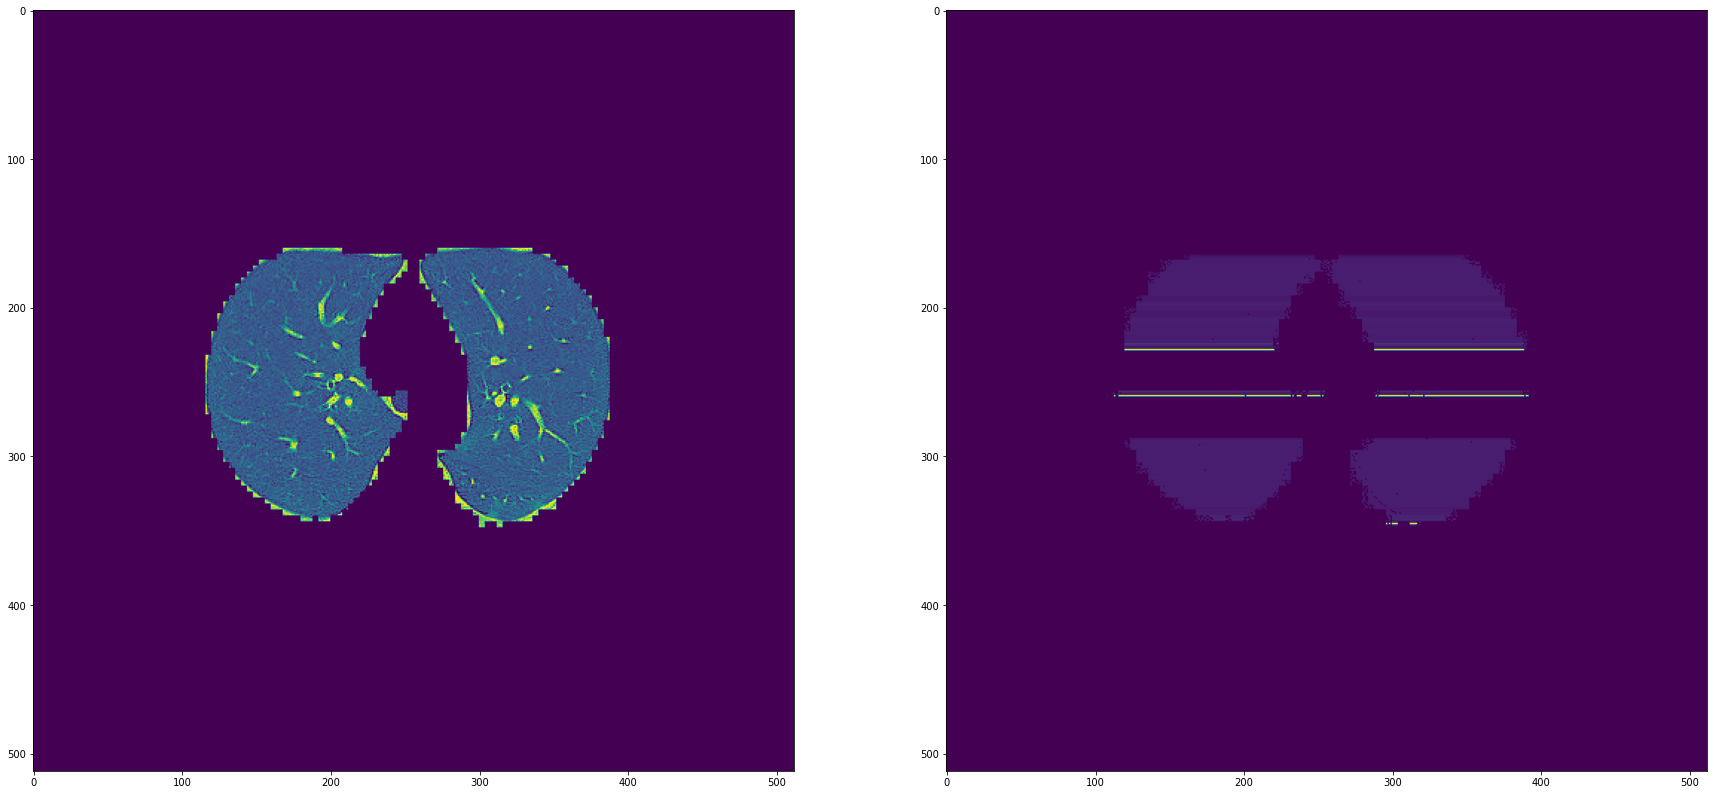

In [ ]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches([30,30])
ax = axes.ravel()

ax[0].imshow(img)
ax[1].imshow(foo_img)

# Sobre CUDA

In [ ]:
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

/usr/local/lib/python3.7/dist-packages/jaxlib/cuda/nvvm/libdevice
/usr/local/cuda-11.1/nvvm/libdevice
/usr/local/cuda-11.0/nvvm/libdevice
/usr/local/cuda-10.1/nvvm/libdevice
/usr/local/cuda-10.0/nvvm/libdevice
/usr/local/cuda-11.1/nvvm/lib64/libnvvm.so
/usr/local/cuda-11.0/nvvm/lib64/libnvvm.so
/usr/local/cuda-10.1/nvvm/lib64/libnvvm.so
/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so


In [ ]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-11.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-11.0/nvvm/lib64/libnvvm.so"

In [ ]:
from numba import cuda
import numba
print(cuda.gpus)

<Managed Device 0>


In [ ]:
from numba import jit
import numpy as np

@jit(nopython=True) 
def matrix_cum_sum_fast(mat):
  """
  qweqwe
  """ 
  N,_ = mat.shape
  ones = np.ones((N,N)).reshape(N,N)
  lower_ones = np.tril(ones)
  uper_ones = lower_ones.T
  result = lower_ones @ mat @ uper_ones
  return result


def matrix_cum_sum_slow(mat):
  """
  qweqwe
  """ 
  N,_ = mat.shape
  ones = np.ones((N,N)).reshape(N,N)
  lower_ones = np.tril(ones)
  uper_ones = lower_ones.T
  return lower_ones @ mat @ uper_ones

In [ ]:
n = 100
mat = np.random.normal( size = n**2).reshape(n,n)

In [ ]:
%%time 
matrix_cum_sum_slow(mat)
print("terminé")

terminé
CPU times: user 1.39 ms, sys: 1.98 ms, total: 3.38 ms
Wall time: 2.93 ms


In [ ]:
%%time 
matrix_cum_sum_fast(mat)
print("terminé")

terminé
CPU times: user 2.61 ms, sys: 991 µs, total: 3.6 ms
Wall time: 4.62 ms


# PRUEBAS -------------------------------

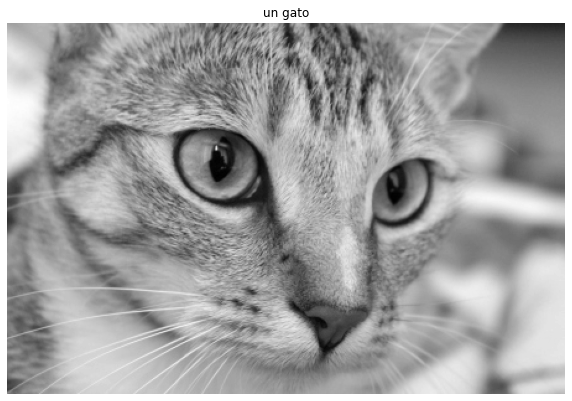

In [ ]:
from skimage import data
import matplotlib.pyplot as plt
from skimage import color
cat = color.rgb2gray( data.chelsea()  )

fig, ax = plt.subplots()
fig.set_size_inches([10,10])
ax.imshow(cat, cmap = 'gray')
ax.set_title("un gato")
ax.axis(False)

pass

  0%|          | 0/80 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


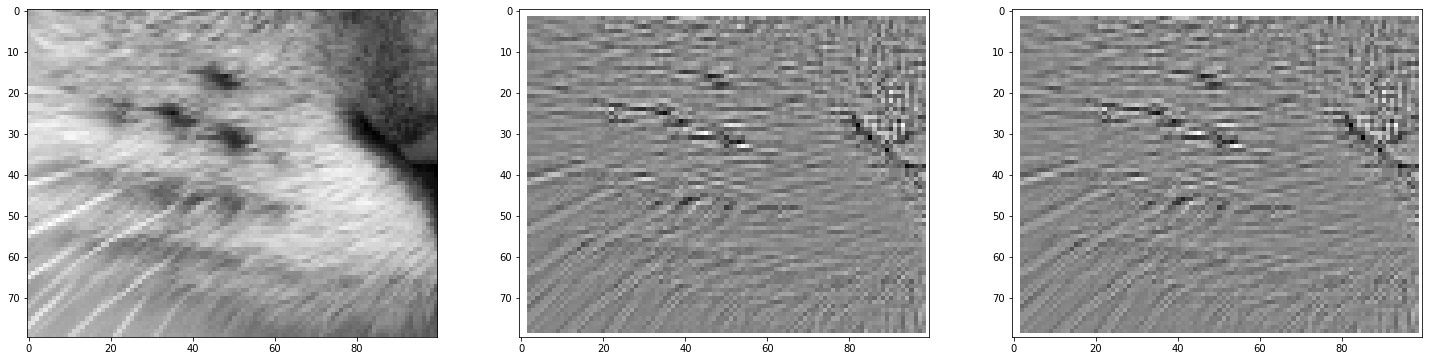

In [ ]:
foo_cat = cat[ 200:280 , 150:250]
N, M = foo_cat.shape
w = 2
n , m = N,M
final_img_q10 = np.zeros( (n,m) )
final_img_2 = np.zeros( (n,m) )
for i in tqdm(range(N)[0:n]):
  for j in range(M)[0:m]:
    min_x = max( [i - w , 0] )
    max_x = min( [i + w , N] )
    min_y = max( [j - w , 0] )
    max_y = min( [j + w , M] )
    #fig, ax = plt.subplots()
    #ax.imshow(foo_cat[ min_x:max_x , min_y:max_y])

    h_10 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y],min_s=2, max_s=4,q=-10)
    h_2 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y],min_s=2, max_s=4,q=2)
    final_img_q10[i,j] = h_10
    final_img_2[i,j] = h_2
    #ax.set_title("i = {}, j = {}".format(i,j))

fig, axes = plt.subplots(1,3)
fig.set_size_inches([25,25])
ax = axes.ravel()
ax[0].imshow(foo_cat,cmap ='gray')
ax[1].imshow(final_img_q10, cmap ='gray')
ax[2].imshow(final_img_2, cmap ='gray')
#ax.set_title("ALL")

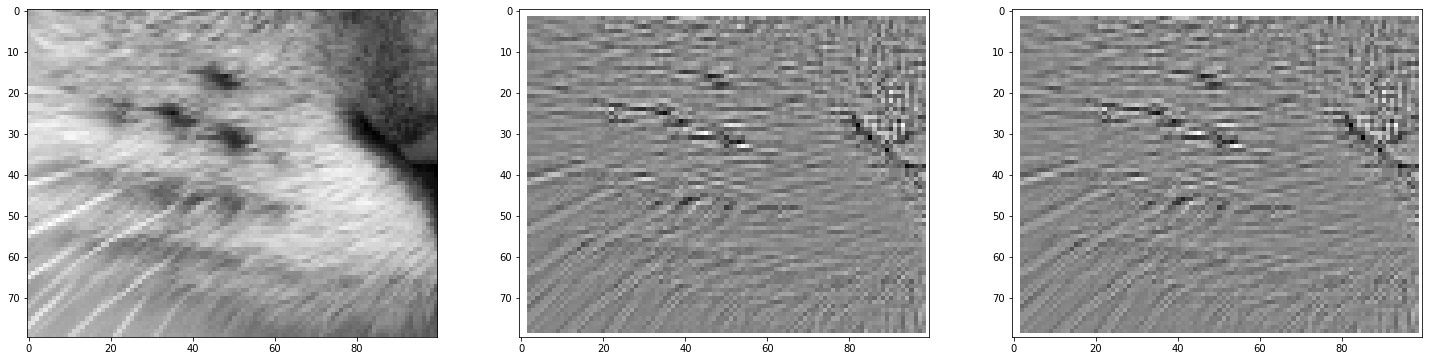

In [ ]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches([25,25])
ax = axes.ravel()
ax[0].imshow(foo_cat,cmap ='gray')
ax[1].imshow( final_img_q10 , cmap ='gray')
ax[2].imshow(final_img_2, cmap ='gray')

nan nan


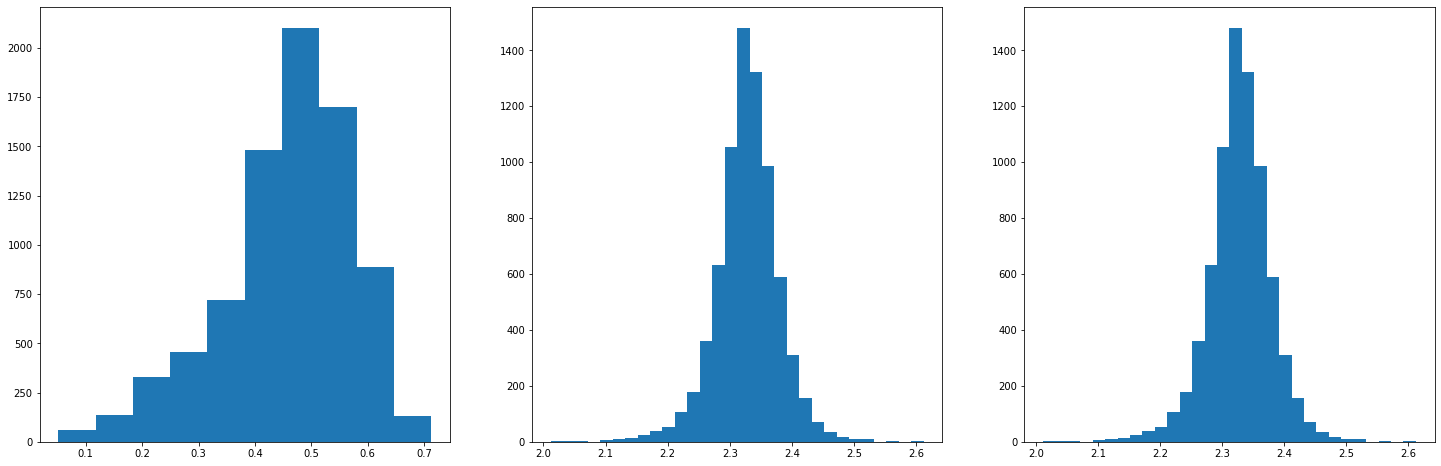

In [ ]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches([25,8])
ax = axes.ravel()
ax[0].hist(foo_cat.ravel())
ax[1].hist(final_img_q10.ravel(), bins = 30)
ax[2].hist(final_img_2.ravel(), bins = 30)
pass

print( np.mean(final_img_q10.ravel() ), np.mean(final_img_2.ravel() ))

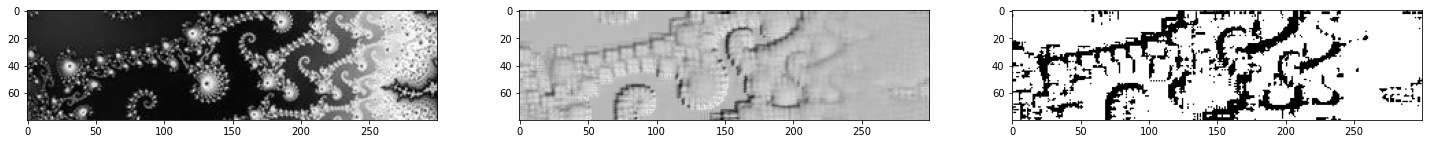

In [ ]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches([25,25])
ax = axes.ravel()
ax[0].imshow(foo_cat,cmap ='gray')
ax[1].imshow( final_img_q10 , cmap ='gray')
ax[2].imshow( final_img_q10 > 2.2, cmap ='gray')

(array([262104.,  65683.,  50379.,  47897.,  45137.,  41145.,  55297.,
         45285.,  64252.,  52869.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

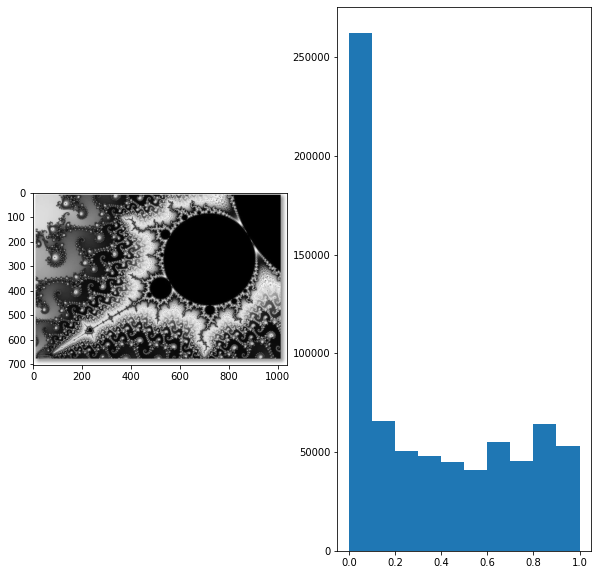

In [ ]:
#@title Fractal de prueba

from skimage.io import imread
from skimage import color
#cat = color.rgb2gray( data.chelsea()  )
fractal = imread("https://m.media-amazon.com/images/I/81ep2kZdU-L._AC_SL1100_.jpg")
fractal = color.rgb2gray(fractal)
fig, axes = plt.subplots(1,2)
fig.set_size_inches([10,10])
ax = axes.ravel()
ax[0].imshow(fractal, cmap = 'gray')
ax[1].hist(fractal.ravel())
#ax.set_title("un fractal")
#ax.axis(False)


  0%|          | 0/80 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CPU times: user 1min 1s, sys: 50.1 s, total: 1min 51s
Wall time: 58.4 s


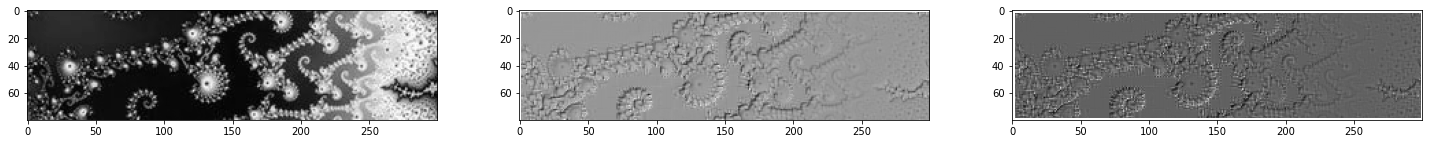

In [ ]:
%%time
foo_cat = fractal[ 200:280 , 200:500]
N, M = foo_cat.shape
w = 2
n , m = N,M
final_img_q10 = np.zeros( (n,m) )
final_img_2 = np.zeros( (n,m) )
for i in tqdm(range(N)[0:n]):
  for j in range(M)[0:m]:
    min_x = max( [i - w , 0] )
    max_x = min( [i + w , N] )
    min_y = max( [j - w , 0] )
    max_y = min( [j + w , M] )
    #fig, ax = plt.subplots()
    #ax.imshow(foo_cat[ min_x:max_x , min_y:max_y])

    h_10 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y],min_s=2, max_s=3,q=-10)
    h_2 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y],min_s=2, max_s=4,q=2)
    final_img_q10[i,j] = h_10
    final_img_2[i,j] = h_2

    #ax.set_title("i = {}, j = {}".format(i,j))

fig, axes = plt.subplots(1,3)
fig.set_size_inches([25,40])
ax = axes.ravel()
ax[0].imshow(foo_cat,cmap ='gray')
ax[1].imshow(final_img_q10, cmap ='gray')
ax[2].imshow(final_img_2, cmap ='gray')

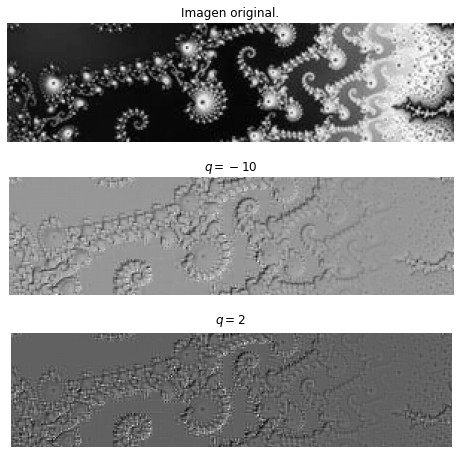

In [ ]:
fig, axes = plt.subplots(3,1)
fig.set_size_inches([8,8])
ax = axes.ravel()

ax[0].imshow(foo_cat,cmap ='gray')
ax[0].set_title("Imagen original.")
ax[1].imshow(final_img_q10, cmap ='gray')
ax[1].set_title("$q = -10$")
ax[2].imshow(final_img_2, cmap ='gray')
ax[2].set_title("$q = 2$")
ax[0].axis(False)
ax[1].axis(False)
ax[2].axis(False)
fig.savefig("Mandelbrotset.pdf")

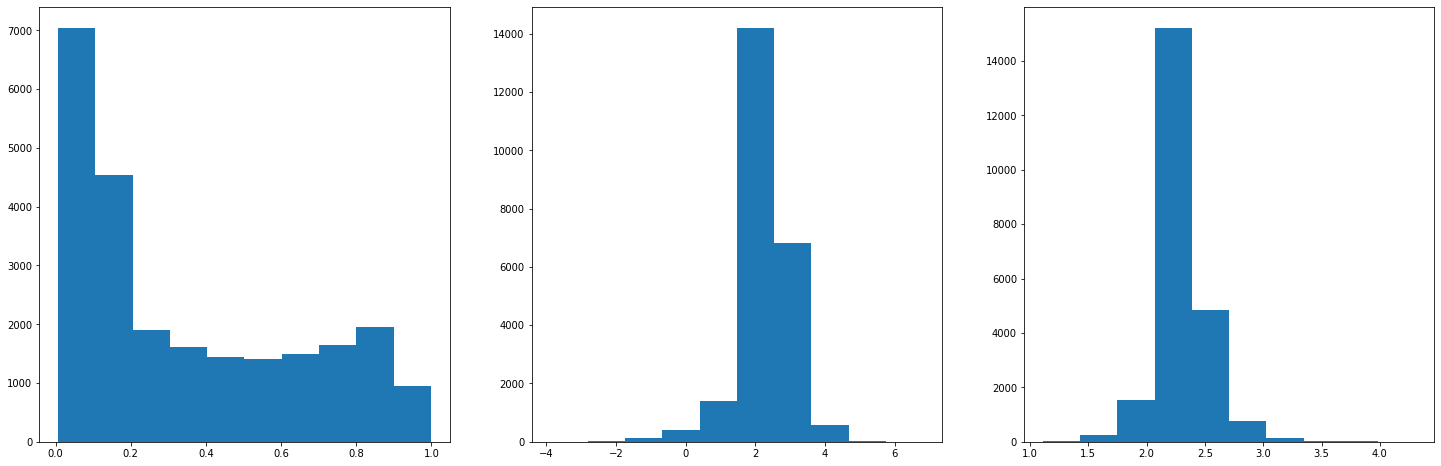

In [ ]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches([25,8])
ax = axes.ravel()
ax[0].hist(foo_cat.ravel())
ax[1].hist(final_img_q10.ravel())
ax[2].hist(final_img_2.ravel())
pass

In [ ]:
#def count_box_interval(array_values, max_n = 100):
  

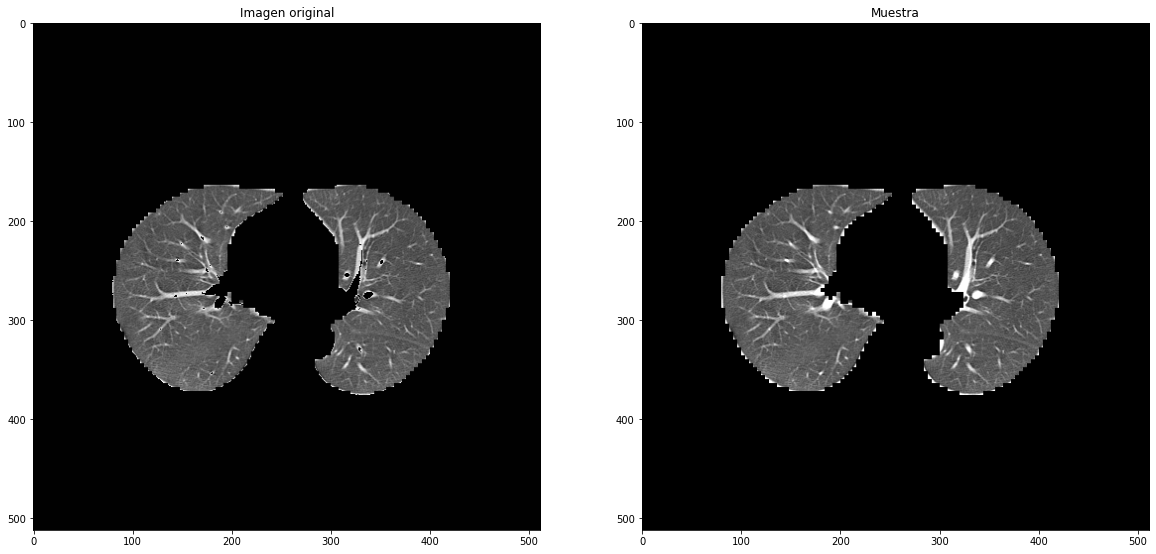

In [ ]:
#@title Fractal de prueba

from skimage.io import imread, imsave
from skimage.exposure import equalize_adapthist

#cat = color.rgb2gray( data.chelsea()  )
#fractal = imread("/content/data/normal/Normal/1867/322/0043.png", as_gray=True)
#Con CVODI
fractal = imread("/content/data/covid/NCP/179/1503/0021.png", as_gray=True)
N,M = fractal.shape
sample_min_x = 0
sample_max_x = N
sample_min_y = 0
sample_max_y = M
# sample_min_x = 150
# sample_max_x = 350
# sample_min_y = 300
# sample_max_y = 400

#fractal = color.rgb2gray(fractal)
fig, axes = plt.subplots(1,2)
ax = axes.ravel()
fig.set_size_inches([20,10])
ax[0].imshow(fractal + 1, cmap = 'gray')
# ax[0].plot([sample_min_y, sample_max_y],
#            [sample_max_x, sample_max_x],
#            color='red')
# ax[0].plot([sample_min_y, sample_max_y],
#            [sample_min_x, sample_min_x],
#            color='red')
# ax[0].plot([sample_min_y, sample_min_y],
#            [sample_min_x, sample_max_x],
#            color='red')
# ax[0].plot([sample_max_y, sample_max_y],
#            [sample_min_x, sample_max_x],
#            color='red')
ax[0].set_title("Imagen original")


foo_cat = fractal[ sample_min_x:sample_max_x , sample_min_y:sample_max_y]
#ax[0].
ax[1].imshow( foo_cat, cmap = 'gray')
ax[1].set_title("Muestra")

#fig.savefig("pulmon_covid.pdf")

#Guardamos 
# imsave('original_image_covid.jpeg',
#        arr = fractal,
#        quality = 100)

# imsave('sample_image_covid.jpeg',
#        arr = foo_cat,
#        quality = 100)

#ax[2].hist( equalize_adapthist( fractal + 1,clip_limit=0.02  ).ravel(), )
#plt.hist(equalize_adapthist( fractal + 1,clip_limit=0.02  ).ravel())
#ax.axis(False)
pass

In [ ]:
%%time


#foo_cat = equalize_adapthist( fractal ,clip_limit=0.02  )
foo_cat = fractal + 1
sample_min_x = 150
sample_max_x = 350
sample_min_y = 300
sample_max_y = 400
foo_cat = foo_cat[ sample_min_x:sample_max_x , sample_min_y:sample_max_y] 
#min_zero = min(foo_cat.ravel())

N, M = foo_cat.shape
w = 2
n , m = N,M
final_img_q10 = np.zeros( (n,m) )
final_img_2 = np.zeros( (n,m) )
for i in tqdm(range(N)[0:n]):
  for j in range(M)[0:m]:
    if fractal[ sample_min_x + i, sample_min_y + j ] > 0:
      min_x = max( [i - w , 0] )
      max_x = min( [i + w , N] )
      min_y = max( [j - w , 0] )
      max_y = min( [j + w , M] )
      h_10 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y] + 1,min_s=2, max_s=3,q=-10)
      h_2 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y] + 1,min_s=2, max_s=3,q=2)
      final_img_q10[i,j] = h_10
      final_img_2[i,j] = h_2
      #print(h_10, h_2)
    else:
      h_10 = 0
      h_2 = 0
    #min_x = max( [i - w , 0] )
    #max_x = min( [i + w , N] )
    #min_y = max( [j - w , 0] )
    #max_y = min( [j + w , M] )
    #fig, ax = plt.subplots()
    #ax.imshow(foo_cat[ min_x:max_x , min_y:max_y])

    #h_10 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y],min_s=2, max_s=4,q=-10)
    #h_2 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y],min_s=2, max_s=4,q=2)
    #final_img_q10[i,j] = h_10
    #final_img_2[i,j] = h_2

    #ax.set_title("i = {}, j = {}".format(i,j))

fig, axes = plt.subplots(1,3)
fig.set_size_inches([25,40])
ax = axes.ravel()
ax[0].imshow(foo_cat,cmap ='gray')
ax[1].imshow(final_img_q10, cmap ='gray')
ax[2].imshow(final_img_2, cmap ='gray')

# imsave('mfdfa_q10_covid.jpeg',
#        arr = final_img_q10,
#        quality = 100)

# imsave('mfdfa_q2_covid.jpeg',
#        arr = final_img_2,
#        quality = 100)

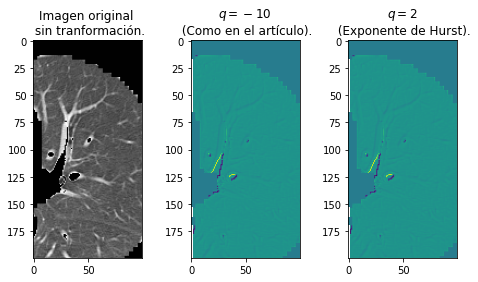

In [ ]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches([8,4])
ax = axes.ravel()
ax[0].imshow(foo_cat,cmap ='gray')
ax[0].set_title("Imagen original \n sin tranformación.")
ax[1].imshow(final_img_q10 )#, cmap ='gray')
ax[1].set_title("$q = -10$ \n (Como en el artículo).")
ax[2].imshow(final_img_2 +1 )#, cmap ='gray')
ax[2].set_title("$q = 2$ \n (Exponente de Hurst).")

fig.savefig("sinequalizador_covid.pdf")

  0%|          | 0/512 [00:00<?, ?it/s]

CPU times: user 1min 42s, sys: 1min 24s, total: 3min 7s
Wall time: 1min 40s


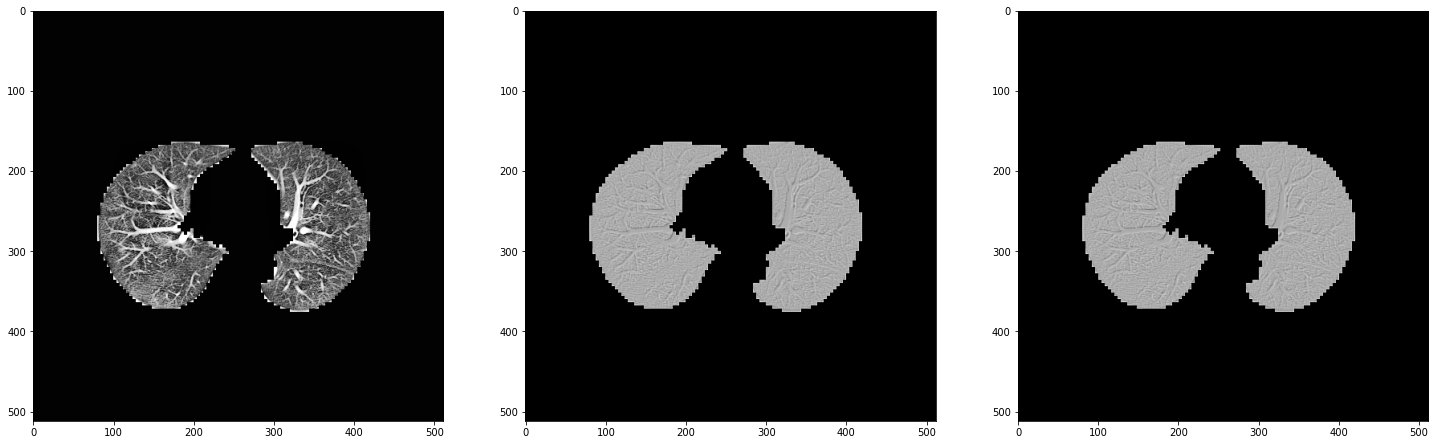

In [ ]:
%%time


foo_cat = equalize_adapthist( fractal ,clip_limit=0.02  )
#foo_cat = foo_cat + 1
# sample_min_x = 150
# sample_max_x = 350
# sample_min_y = 300
# sample_max_y = 400
foo_cat = foo_cat[ sample_min_x:sample_max_x , sample_min_y:sample_max_y] 
#min_zero = min(foo_cat.ravel())

N, M = foo_cat.shape
w = 2
n , m = N,M
final_img_q10 = np.zeros( (n,m) )
final_img_2 = np.zeros( (n,m) )
for i in tqdm(range(N)[0:n]):
  for j in range(M)[0:m]:
    if fractal[ sample_min_x + i, sample_min_y + j ] > 0:
      min_x = max( [i - w , 0] )
      max_x = min( [i + w , N] )
      min_y = max( [j - w , 0] )
      max_y = min( [j + w , M] )
      #print("HAgo algo")
      h_10 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y] + 1,min_s=2, max_s=3,q=-10)
      #print("HAgo otro")
      h_2 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y] + 1,min_s=2, max_s=3,q=2)
      final_img_q10[i,j] = h_10
      final_img_2[i,j] = h_2
      #print(h_10, h_2)
    else:
      h_10 = 0
      h_2 = 0
    #min_x = max( [i - w , 0] )
    #max_x = min( [i + w , N] )
    #min_y = max( [j - w , 0] )
    #max_y = min( [j + w , M] )
    #fig, ax = plt.subplots()
    #ax.imshow(foo_cat[ min_x:max_x , min_y:max_y])

    #h_10 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y],min_s=2, max_s=4,q=-10)
    #h_2 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y],min_s=2, max_s=4,q=2)
    #final_img_q10[i,j] = h_10
    #final_img_2[i,j] = h_2

    #ax.set_title("i = {}, j = {}".format(i,j))

fig, axes = plt.subplots(1,3)
fig.set_size_inches([25,40])
ax = axes.ravel()
ax[0].imshow(foo_cat,cmap ='gray')
ax[1].imshow(final_img_q10, cmap ='gray')
ax[2].imshow(final_img_2, cmap ='gray')

# imsave('sample_contrast_covid.jpeg',
#        arr = foo_cat,
#        quality = 100)

# imsave('mfdfa_contrast_q10_covid.jpeg',
#        arr = final_img_q10,
#        quality = 100)

# imsave('mfdfa_contrast_q2_covid.jpeg',
#        arr = final_img_2,
#        quality = 100)

/usr/local/lib/python3.7/dist-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type bool to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


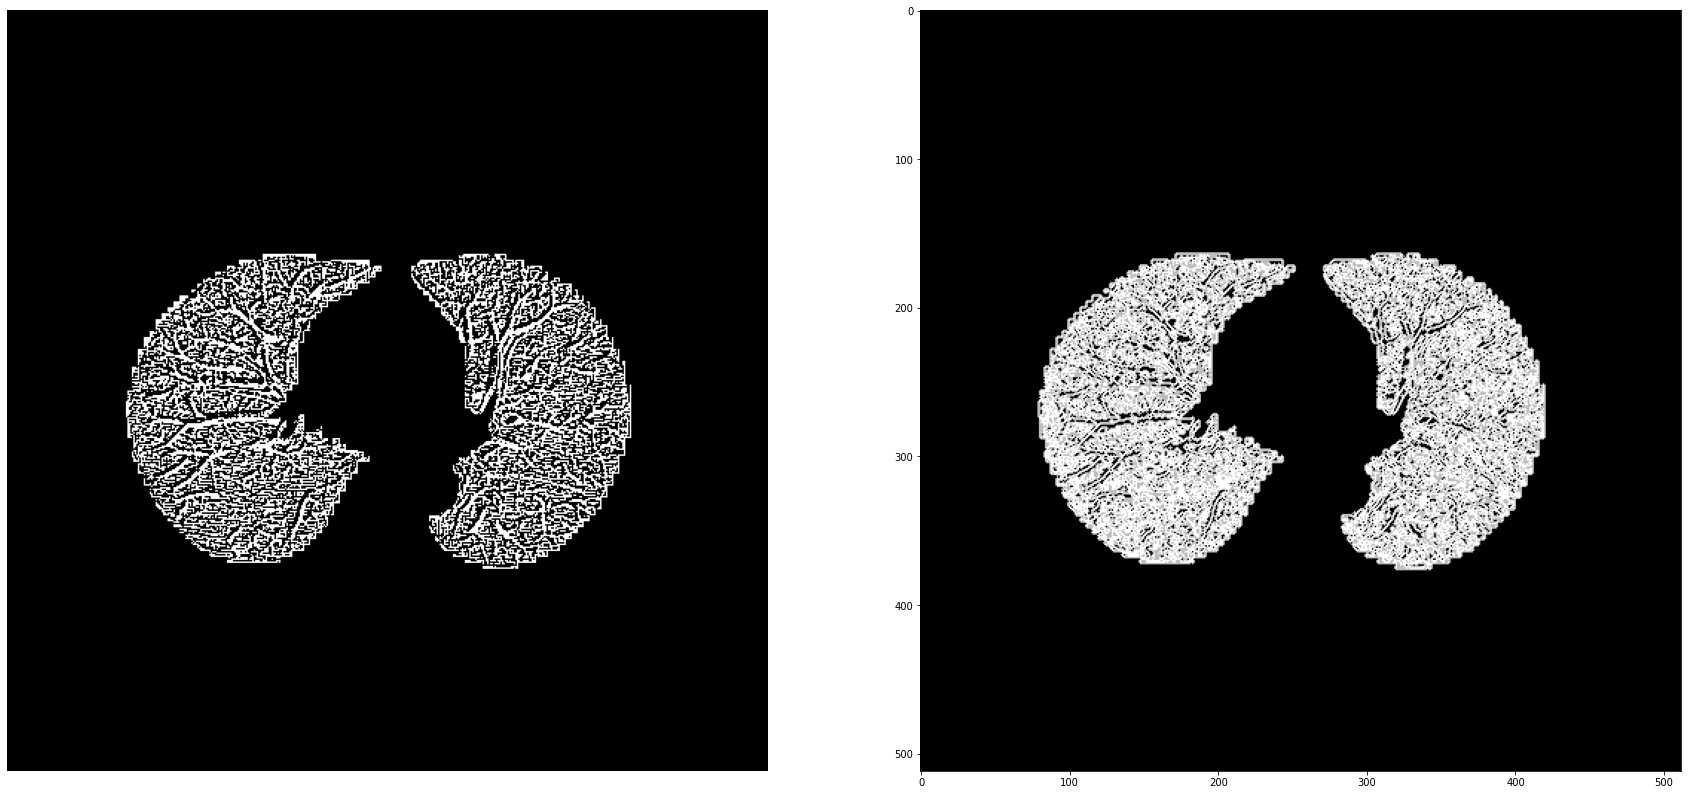

In [ ]:
#@title Network segmentation
from skimage.io import imsave
from skimage.morphology import skeletonize
from skimage.filters.rank import entropy
from skimage.morphology import disk
#from skimage import filters

fig, axes = plt.subplots(1,2)
fig.set_size_inches([30,15])
ax = axes.ravel()

array_foo = final_img_q10.ravel()
array_foo = array_foo[(array_foo > 0)  ]
epsi = np.var(array_foo) * 2
ax[0].axis(False)
ax[0].imshow( (final_img_q10 > np.mean(array_foo ) ), cmap = 'gray' )#+ epsi) &  (final_img_q10 > np.mean(array_foo ) - epsi) )
ax[1].imshow( entropy(final_img_q10 > np.mean(array_foo ) , disk(1)), cmap = 'gray' )
#ax[1].imshow( skeletonize(final_img_q10 > np.mean(array_foo ) , method='lee'), cmap = 'gray' )


#ax[1].hist( array_foo, bins = 30 )
#print( np.mean(array_foo ))

In [ ]:
img_final_foo = final_img_q10 > np.mean(array_foo )
#segmentada = make_binary_segmentation( img_final_foo )

NameError: ignored

In [ ]:
#Algo más pequeño
foo_img = img_final_foo[:,:]
#segmentada = make_binary_segmentation( foo_img , k = 10, lmd= 0.5)
"""
Valores
"""
k = 1
lmd = 2.5
binaryimg = foo_img
N,M = binaryimg.shape
G,s,t = make_graph_segmentation( binaryimg , k= k, lmd = lmd)
cvalue,partition = nx.minimum_cut(G,_s = s,_t = t, capacity = 'weight')
real_pixels = np.array(list(partition[0]))
array_pixels = np.arange(s)
segment_img = np.isin(array_pixels, real_pixels).reshape(N,M)

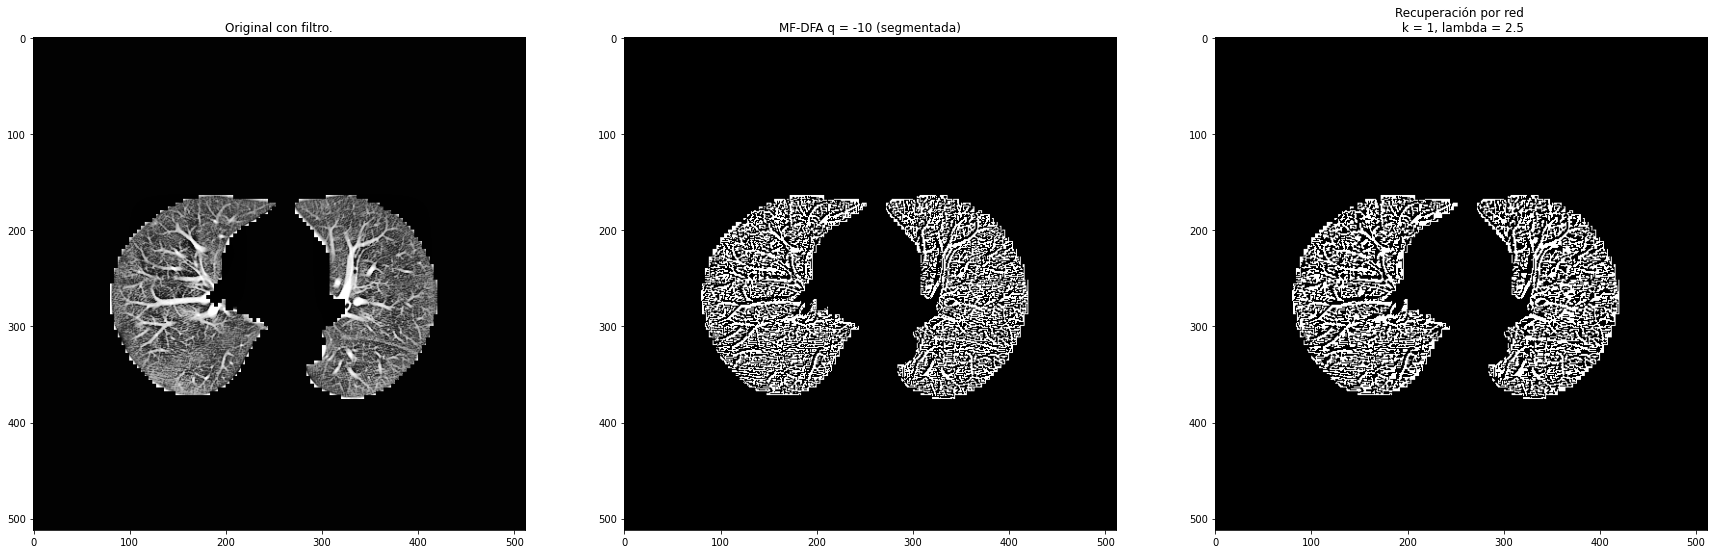

In [ ]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches([30,15])
ax = axes.ravel()

ax[0].imshow(foo_cat, cmap = 'gray' )
ax[0].set_title('Original con filtro.')
ax[1].imshow(foo_img, cmap = 'gray')
ax[1].set_title('MF-DFA q = -10 (segmentada)')
ax[2].imshow(segment_img, cmap = 'gray')
ax[2].set_title('Recuperación por red \n k = {}, lambda = {}'.format(k,lmd))
pass

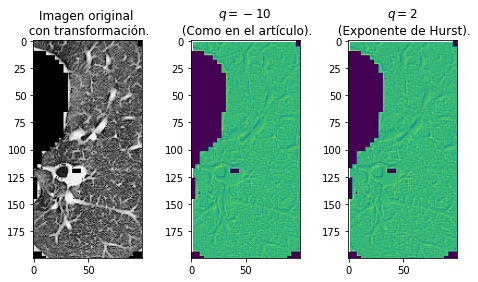

In [ ]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches([8,4])
ax = axes.ravel()
ax[0].imshow(foo_cat,cmap ='gray')
ax[0].set_title("Imagen original \n con transformación.")
ax[1].imshow(final_img_q10 )#, cmap ='gray')
ax[1].set_title("$q = -10$ \n (Como en el artículo).")
ax[2].imshow(final_img_2 +1 )#, cmap ='gray')
ax[2].set_title("$q = 2$ \n (Exponente de Hurst).")

fig.savefig("conequalizador_covid.pdf")

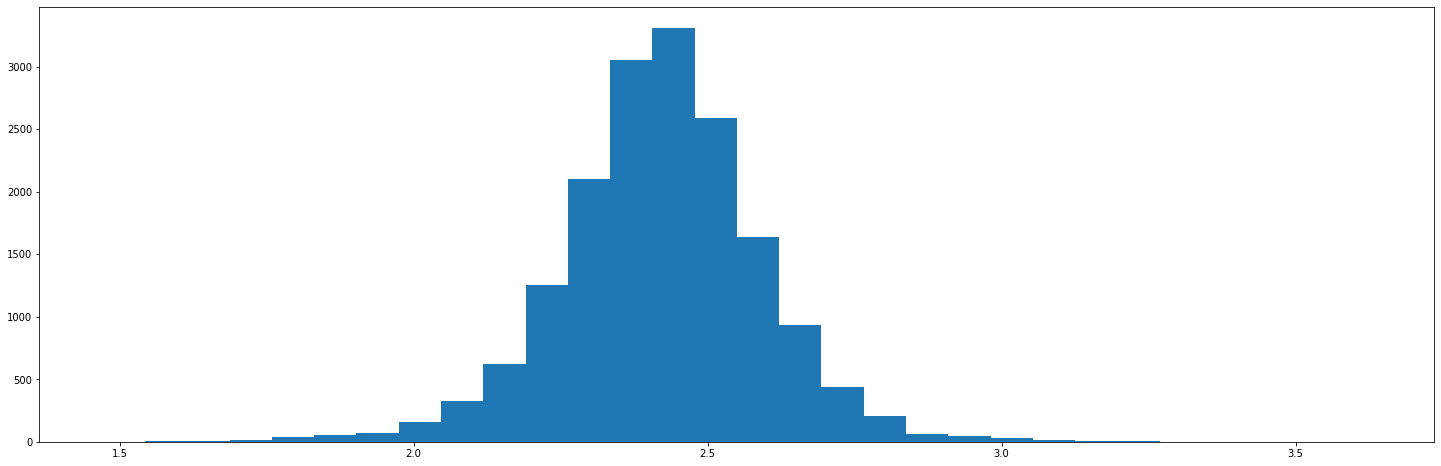

In [ ]:
foo_hist = final_img_q10.ravel()
foo_hist = foo_hist[ foo_hist > 0]

fig, axes = plt.subplots(1)
fig.set_size_inches([25,8])
#ax = axes.ravel()
axes.hist(foo_hist, bins= 30)
#ax[1].hist(final_img_q10.ravel(), bins = 30)
#ax[2].hist(final_img_2.ravel(), bins = 30)
pass

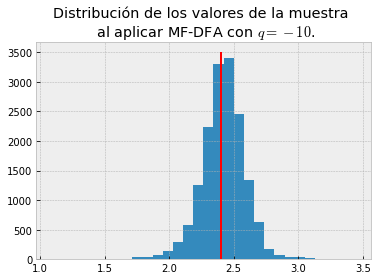

In [ ]:
foo_hist = final_img_q10.ravel()
foo_hist = foo_hist[ foo_hist > 0]
n = 2
a = foo_hist[0]
b = foo_hist[-1]
step = (b-a) / n
plt.style.use('bmh')
fig, axes = plt.subplots(1)
#fig.set_size_inches([7,3])
#ax = axes.ravel()
axes.hist(foo_hist, bins= 30)
for i in range(n-1):
  axes.vlines(x = a + (i+1)*step, ymin=0,ymax=3500, color = 'red')
axes.set_title("Distribución de los valores de la muestra \n al aplicar MF-DFA con $q = -10$.")
#ax[1].hist(final_img_q10.ravel(), bins = 30)
#ax[2].hist(final_img_2.ravel(), bins = 30)
fig.savefig("distribucion_covid.pdf")
pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: seg_izquierda.jpeg is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: seg_derecha.jpeg is a low contrast image


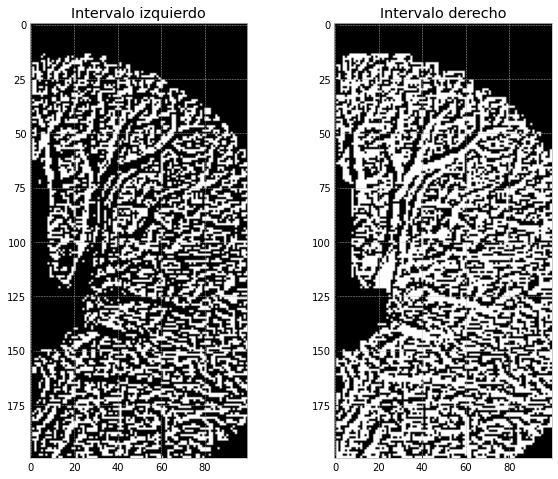

In [ ]:
def get_interval(foo_array, n = 2):
  N = len(foo_array)
  a = foo_array[0]
  b = foo_array[-1]
  #a = np.min(foo_array)
  #b = np.max(foo_array)
  step = (b-a) / n
  list_inter = []
  for i in range(n):
    lower = a + step * i
    upper = a + step * (i+1)
    list_inter.append( (lower, upper) )
  return list_inter

def get_boolean_matrix(img, interval):
  lower = interval[0]
  upper = interval[1]
  image_new = (lower < img) & (img < upper)
  return image_new

def get_box_counting(img, delta):
  N,M = img.shape
  N_d = int(N/ delta)
  M_d = int(M/ delta)
  count_box = 0
  for i in range(N_d):
    for j in range(M_d):
      count_inf = img[i*delta:(i+1)*delta:, j*delta:(j+1)*delta ].ravel()
      if np.sum(count_inf) > 0:
        count_box += 1
  return count_box

foo_array = final_img_q10.ravel()
foo_array = foo_array[ foo_array > 0]
list_int = get_interval( foo_array , n = 2)

fig, axes = plt.subplots(1,2)
fig.set_size_inches([10,8])
ax = axes.ravel()
i = 0
for interval in list_int:
  img_seg = get_boolean_matrix(final_img_q10, interval=interval)
  #print(get_box_counting(img_seg, delta= 2))
  if i ==0:
    ax[i].set_title('Intervalo izquierdo')
    imsave(fname='seg_izquierda.jpeg',
        arr = img_seg.astype(int),
       quality = 100)
  else:
    ax[i].set_title('Intervalo derecho')
    imsave(fname='seg_derecha.jpeg',
        arr = img_seg.astype(int),
       quality = 100)
  ax[i].imshow(img_seg, cmap='gray')
  i+=1
fig.savefig("segmemeantacion_{}".format(i))


In [ ]:
img_seg

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

#Prueba de espectro multifractal

In [ ]:
import numpy as np
from IPython.html.widgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt

#widgets.FloatRangeSlider(value = 2.5,
#                         min = 2.0,
#                         max = 3.0,
#                         step = 0.5)



def identificarlq(s): 
    delta = 10**(-2)
    # f funcion a integrar **
    #def f(x):
        #return x*x
    # f funcion a integrar
    
    delta = 10**(-1)
    image_new = (s < final_img_q10) & (final_img_q10 < s + delta)
    
    fig, axes = plt.subplots(1,2)
    ax = axes.ravel()
    fig.set_size_inches([20,10])
    
    # discretizacion para la cuadratura
    ax[0].set_title("Imagen original \n por $LH_{-10}$")
    ax[0].imshow(final_img_q10)

    ax[1].imshow(image_new, cmap='bone')

image_foo = final_img_q10.ravel() 
values_sample = image_foo[image_foo > 0]

interact(identificarlq,s=widgets.FloatSlider(value=np.mean(values_sample),
                                          min = np.min(values_sample),
                                          max = np.max(values_sample),
                                          step = 0.01))

interactive(children=(FloatSlider(value=2.417814359845019, description='s', max=3.444141006529424, min=1.08493…

<function __main__.identificarlq>

# Make some covid and normal patients.  We use the pseudo code to prove the process in binary images.



In [ ]:
from natsort import natsorted, ns
from skimage.io import imread

path_covid_patients = 'data/covid/NCP'
path_normal_patients = 'data/normal/Normal'

path_covid_mfdfa = '/content/drive/MyDrive/covid-ct-bronquial-tree/datamf/mfdfa/covid'
path_normal_mfdfa = '/content/drive/MyDrive/covid-ct-bronquial-tree/datamf/mfdfa/normal'

list_id_pat_covid = os.listdir(path_covid_patients)
list_id_pat_normal = os.listdir(path_normal_patients)



In [ ]:
#@title Normal Patients
dict_ids_images_normal = {}

for idpatient in list_id_pat_normal[1:5]:
  path_patient = '{}/{}'.format(path_normal_patients,
                                idpatient)
  list_ct = os.listdir(path_patient)[0:1]
  final_ct = list_ct[0]
  path_images_ct_patient = '{}/{}'.format(path_patient,
                                          final_ct)
  list_images_patient = os.listdir(path_images_ct_patient )

  list_array_images_patient = list()
  print(idpatient)
  for image in tqdm(natsorted(list_images_patient)[0:]):
    path_image_patient = '{}/{}'.format(path_images_ct_patient,
                                        image)
    #The name of fractal is just for reference
    fractal = imread(path_image_patient, as_gray=True) 

    foo_cat = equalize_adapthist( fractal + 1,clip_limit=0.02  )
    N, M = foo_cat.shape
    w = 2
    n , m = N,M
    final_img_q10 = np.zeros( (n,m) )
    #final_img_2 = np.zeros( (n,m) )
    for i in range(N)[0:n]:
      for j in range(M)[0:m]:
        if fractal[  i,  j ] > 0:
          min_x = max( [i - w , 0] )
          max_x = min( [i + w , N] )
          min_y = max( [j - w , 0] )
          max_y = min( [j + w , M] )
          #print("HAgo algo")
          h_10 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y] + 1,min_s=2, max_s=3,q=-10)
          #print("HAgo otro")
          #h_2 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y] + 1,min_s=2, max_s=3,q=2)
          final_img_q10[i,j] = h_10
        else:
          h_10 = 0
          h_2 = 0

    list_array_images_patient.append(final_img_q10)
  dict_ids_images_normal[idpatient] = list_array_images_patient

  #------------------------------------------
  #Comment the below lines if you don't want to save the image array 
  #in the Drive memory
  #------------------------------------------
  stack_normal = np.stack(list_array_images_patient )
  #np.save('{}/{}'.format(path_normal_mfdfa, idpatient), 
  #        stack_normal)

1880


  0%|          | 0/83 [00:00<?, ?it/s]

1861


  0%|          | 0/76 [00:00<?, ?it/s]

1876


  0%|          | 0/97 [00:00<?, ?it/s]

1869


  0%|          | 0/94 [00:00<?, ?it/s]

In [ ]:
dict_ids_images_normal.keys()

for id in dict_ids_images_normal:
  stack_normal = np.stack(dict_ids_images_normal[id])
  np.save('{}/{}'.format(path_normal_mfdfa, id), 
          stack_normal)

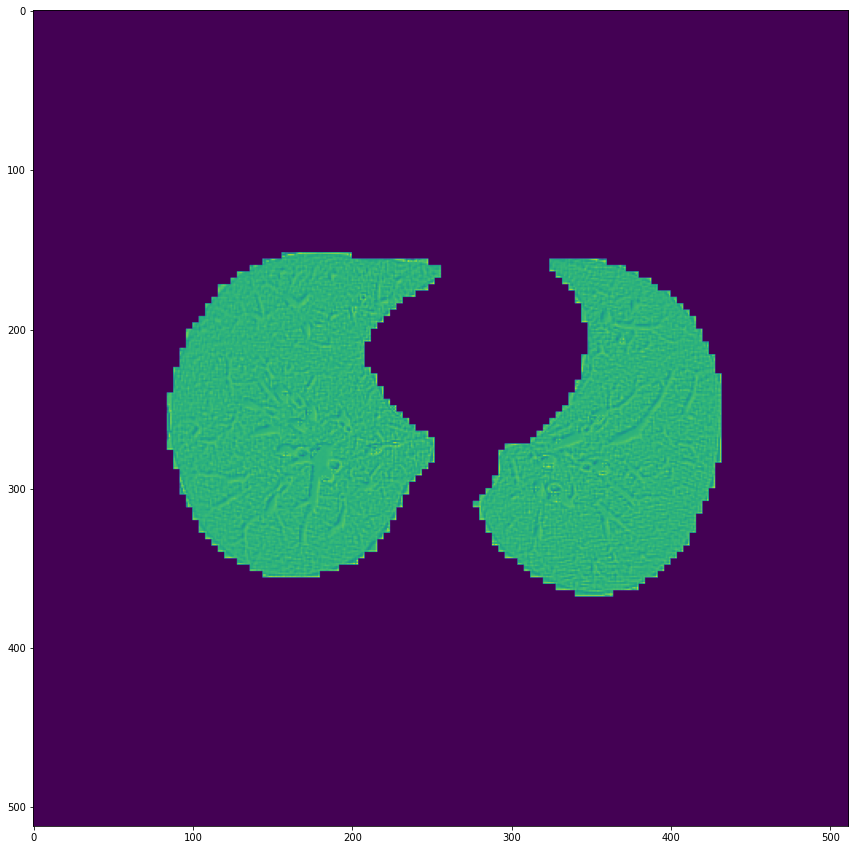

In [ ]:
foo_normal = np.load('/content/drive/MyDrive/covid-ct-bronquial-tree/datamf/mfdfa/normal/1880.npy')
fig, ax = plt.subplots()
fig.set_size_inches([15,15])
ax.imshow(foo_normal[50])
pass

In [ ]:
#@title Covid Patients
dict_ids_images_covid = {}

for idpatient in list_id_pat_covid[2:4]:
  path_patient = '{}/{}'.format(path_covid_patients,
                                idpatient)
  list_ct = os.listdir(path_patient)[0:1]
  final_ct = list_ct[0]
  path_images_ct_patient = '{}/{}'.format(path_patient,
                                          final_ct)
  list_images_patient = os.listdir(path_images_ct_patient )

  list_array_images_patient = list()

  for image in tqdm(natsorted(list_images_patient)[0:]):
    path_image_patient = '{}/{}'.format(path_images_ct_patient,
                                        image)
    #The name of fractal is just for reference
    fractal = imread(path_image_patient, as_gray=True) 

    foo_cat = equalize_adapthist( fractal + 1,clip_limit=0.02  )
    N, M = foo_cat.shape
    w = 2
    n , m = N,M
    final_img_q10 = np.zeros( (n,m) )
    #final_img_2 = np.zeros( (n,m) )
    for i in range(N)[0:n]:
      for j in range(M)[0:m]:
        if fractal[ i,  j ] > 0:
          min_x = max( [i - w , 0] )
          max_x = min( [i + w , N] )
          min_y = max( [j - w , 0] )
          max_y = min( [j + w , M] )
          #print("HAgo algo")
          h_10 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y] + 1,min_s=2, max_s=3,q=-10)
          #print("HAgo otro")
          #h_2 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y] + 1,min_s=2, max_s=3,q=2)
          final_img_q10[i,j] = h_10
        else:
          h_10 = 0
          h_2 = 0

    list_array_images_patient.append(final_img_q10)
  dict_ids_images_covid[idpatient] = list_array_images_patient

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
dict_ids_images_covid.keys()

for id in dict_ids_images_covid:
  stack_normal = np.stack(dict_ids_images_covid[id])
  np.save('{}/{}'.format(path_covid_mfdfa, id), 
          stack_normal)

In [ ]:
#plt.imshow(dict_ids_images_normal['1872'])
stack_normal = np.stack(dict_ids_images_normal['1890'] )
np.save('normal', stack_normal)

#fig, ax = plt.subplots()
#fig.set_size_inches([15,15])
#ax.imshow( dict_ids_images_normal['1890'][49] )

In [ ]:
#dict_ids_images_normal['1890']
stack_normal = np.stack( dict_ids_images_covid['1000'] )
np.savetxt('covid', stack_normal)

ValueError: ignored

In [ ]:
!mv '/content/covid.npy' '/content/drive/MyDrive/covid-ct-bronquial-tree/datamf/mfdfa'  
!mv '/content/normal.npy' '/content/drive/MyDrive/covid-ct-bronquial-tree/datamf/mfdfa'  

mv: cannot stat '/content/covid.npy': No such file or directory
mv: cannot stat '/content/normal.npy': No such file or directory


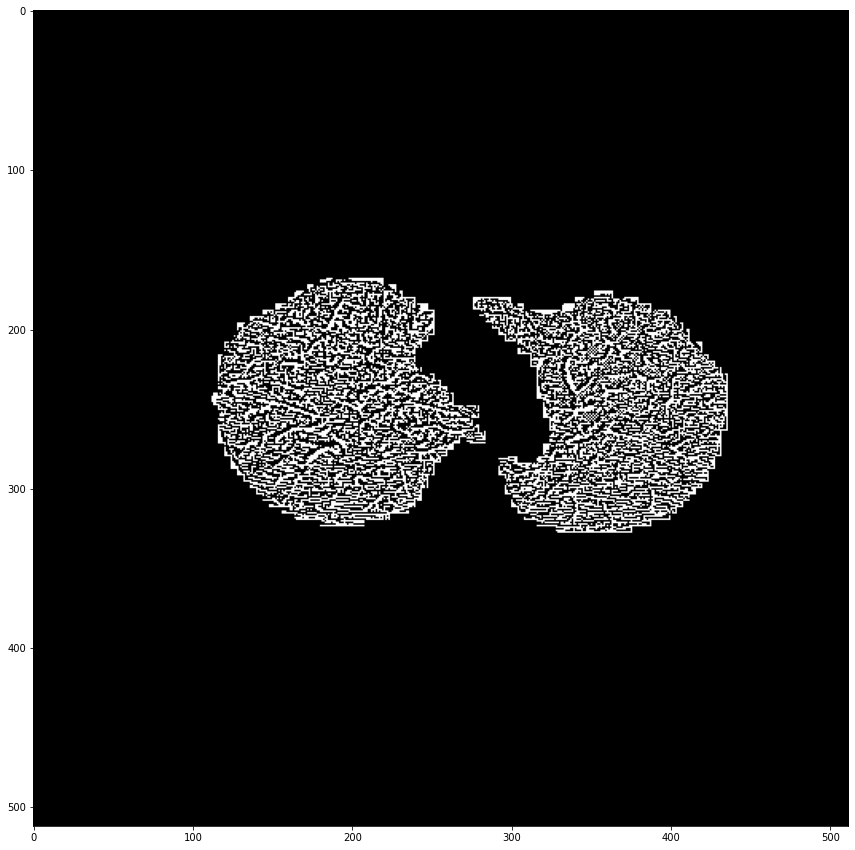

In [ ]:
#@title To read the examples files of covid and normal patients
multiarray_covid = np.load('/content/drive/MyDrive/covid-ct-bronquial-tree/datamf/mfdfa/covid.npy')
multiarray_normal = np.load('/content/drive/MyDrive/covid-ct-bronquial-tree/datamf/mfdfa/normal.npy')


#plt.imshow(dict_ids_images_covid['1000'][20])
#len(dict_ids_images_covid['1000'])
img_foo = multiarray_normal[20] > np.mean(multiarray_normal[20].ravel()[multiarray_normal[20].ravel() > 0] )

fig, ax = plt.subplots()
fig.set_size_inches([15,15])
ax.imshow(img_foo, cmap='gray')

In [ ]:
foo_cat = equalize_adapthist( fractal + 1,clip_limit=0.02  )
#foo_cat = foo_cat + 1
# sample_min_x = 150
# sample_max_x = 350
# sample_min_y = 300
# sample_max_y = 400
foo_cat = foo_cat[ sample_min_x:sample_max_x , sample_min_y:sample_max_y] 
#min_zero = min(foo_cat.ravel())

N, M = foo_cat.shape
w = 2
n , m = N,M
final_img_q10 = np.zeros( (n,m) )
final_img_2 = np.zeros( (n,m) )
for i in tqdm(range(N)[0:n]):
  for j in range(M)[0:m]:
    if fractal[ sample_min_x + i, sample_min_y + j ] > 0:
      min_x = max( [i - w , 0] )
      max_x = min( [i + w , N] )
      min_y = max( [j - w , 0] )
      max_y = min( [j + w , M] )
      #print("HAgo algo")
      h_10 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y] + 1,min_s=2, max_s=3,q=-10)
      #print("HAgo otro")
      h_2 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y] + 1,min_s=2, max_s=3,q=2)
      final_img_q10[i,j] = h_10
      final_img_2[i,j] = h_2
      #print(h_10, h_2)
    else:
      h_10 = 0
      h_2 = 0

# Con archivos DCIM - final

# New Section

In [ ]:
#!pip install dicom
#!pip install pydicom --upgrade
#!pip install pylibjpeg
#!pip install pillow
#!pip install pylibjpeg pylibjpeg-libjpeg pydicom
!pip install tensorflow_io

     |████████████████████████████████| 22.7 MB 2.9 MB/s 
     |████████████████████████████████| 2.1 MB 53.6 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pydicom as dicom
import pylibjpeg
import tensorflow as tf
import tensorflow_io as tfio

from natsort import natsorted, ns
from skimage.color import rgb2gray
#import pillow

path_dicom_tar = '/content/drive/MyDrive/covid-ct-bronquial-tree/data/COVID-CT-MD.zip'

path_covid_cases = '/content/dcimdata/COVID-19 Cases'
path_cap_cases = '/content/dcimdata/Cap Cases'
path_normal_cases = '/content/dcimdata/Normal Cases'

list_covid_patients = os.listdir(path_covid_cases)
list_normal_patients = os.listdir(path_normal_cases)

#print(natsorted(list_covid_patients))

In [ ]:
#import pydicom
import pydicom.data
#Vemos el primer paciente
data_patient = '{}/{}'.format(path_covid_cases, list_covid_patients[0])
list_data_patient = natsorted(os.listdir(data_patient))

path_single_file = '{}/{}'.format(data_patient, list_data_patient[50])
#path_single_file

image_bytes = tf.io.read_file(path_single_file)
image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)
image_gray = rgb2gray(image.numpy()[0,:,:,0])

fig, axes = plt.subplots(1,2)
fig.set_size_inches([15,15])
ax = axes.ravel()

ax[0].imshow(image.numpy()[0,:,:,0], cmap= 'bone')
ax[1].set_title('Distribución de los pixeles.')
ax[1].hist(image_gray.ravel(), bins= 30)
ax[1].set_yscale('log')

#foo_file = dicom.dcmread(path_single_file, stop_before_pixels=True)
#foo_file.pixel_array
#pydicom.data.data_manager.get_files(data_patient, list_data_patient[0])[0]
#foo_file.pixel_array

# The new version; with NeuralNetworks

In [ ]:
#@title Install missing packages.
!pip install segmentation-models

In [10]:
#@title Git Clone of the parallel code. 
!git clone https://github.com/ErickMM98/covid-ct-network-analysis.git
!mv /content/covid-ct-network-analysis/mfdfa.py /content

Cloning into 'covid-ct-network-analysis'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 58 (delta 19), reused 15 (delta 2), pack-reused 0
Unpacking objects: 100% (58/58), done.


CPU times: user 42 s, sys: 1min, total: 1min 42s
Wall time: 1min 6s


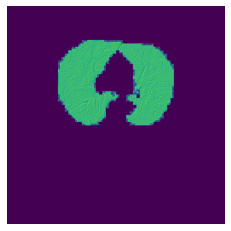

In [16]:
%%time
import segmentation_models as sm
import mfdfa
import matplotlib.pyplot as plt
from skimage.io import imread


q = -10
nworkers = 10


img = imread('/content/data/covid/NCP/1029/2599/0012.jpg')


parallel_mfdfa = mfdfa.MFDFAImage(image=img,
                                  nworkers=nworkers)

foo = parallel_mfdfa.run()


fig, ax = plt.subplots()
ax.imshow(foo)
ax.axis(False)
fig.show()

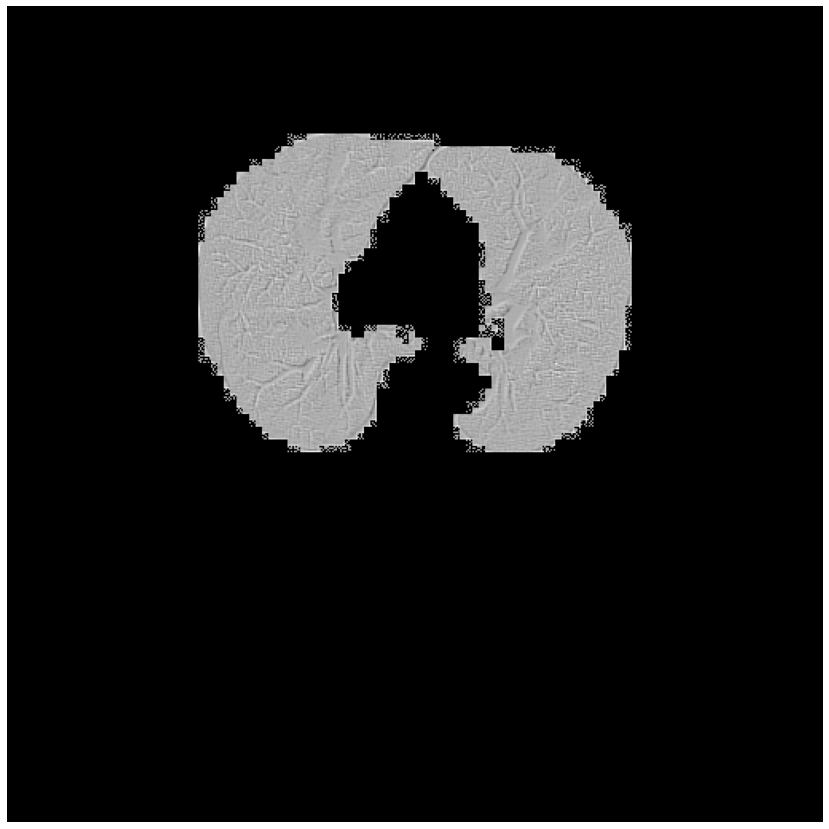

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches([15,15])
ax.imshow(foo, cmap = 'gray')
ax.axis(False)
fig.show()

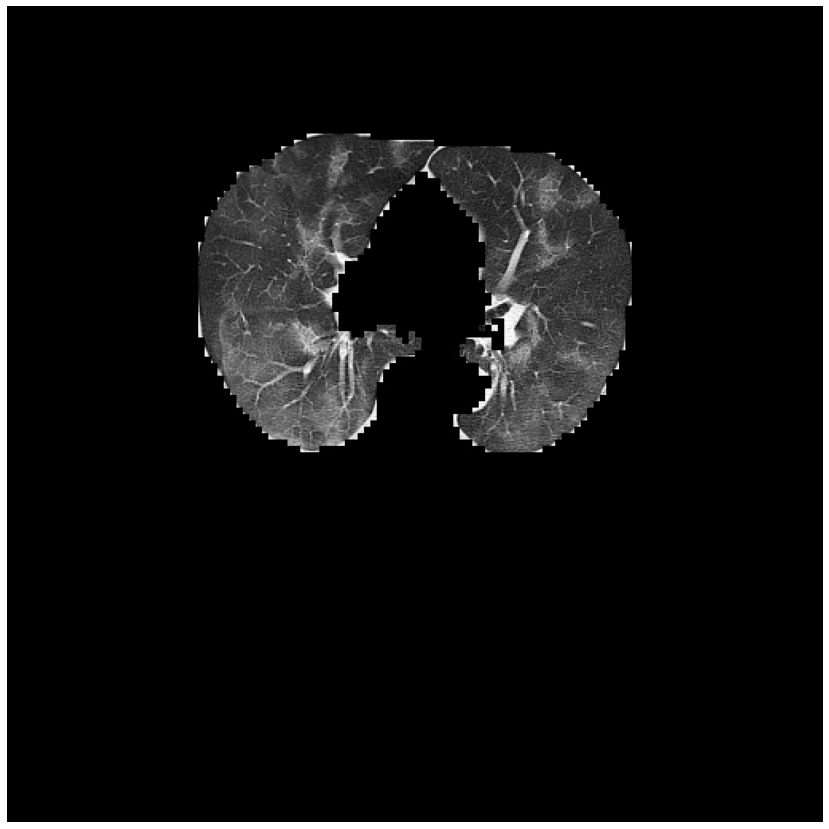

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches([15,15])
ax.imshow(img, cmap = 'gray')
ax.axis(False)
fig.show()